# Spoken Language Processing 2022-23


Before you turn this notebook in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).


---

# Lab1 - Speech Signal Processing

_Luis Caldas de Oliveira_

Speech signal processing is a subfield of signal processing that deals with the analysis, synthesis, and transformation of speech signals. Speech is a complex signal that conveys information about the content, context, and emotional state of a speaker. The goal of speech signal processing is to extract useful information from speech signals and to make them more accessible and useful for various applications.

Speech signal processing techniques play an important role in preparing datasets and in extracting features from speech signals. These features can be used as inputs to machine learning models for various speech-related tasks such as speech recognition, speaker identification, emotion recognition, and language identification.

Feature extraction in speech signal processing typically involves transforming the raw speech signal into a set of numerical features that can be used to represent different aspects of the signal. Some commonly used features in speech signal processing include:

- Mel Frequency Cepstral Coefficients (MFCCs): These are widely used features that represent the spectral envelope of the speech signal.

- Linear Predictive Coding (LPC) coefficients: These features represent the filter parameters that approximate the vocal tract of a speaker.

- Fundamental Frequency (F0): This feature represents the pitch or fundamental frequency of the speech signal.

- Energy and Zero Crossing Rate (ZCR): These features represent the level of energy and the number of times the speech signal crosses zero, respectively.


This lab assignment will introduce some tools and concepts for the manipulation and analysis of speech signals.

This document was inspired by the "Introduction to the acquisition, visualization and processing of speech corpora", "Lab1" and "Lab2" lab assignments by Prof. Isabel Trancoso.

## Introduction

### T1: Group identification

Initialize the variable `group_id` with the number that Fenix assigned to your group and `student1_name`, `student1_id`, `student2_name` and `student2_id` with your names and student numbers.


In [36]:
group_id = 3
student1_name = "Duarte Almeida"
student1_id   = 95565
student2_name = "Leonor Barreiros"
student2_id   = 95618

print(f"Group number: {group_id}")
print(f"Student 1: {student1_name} ({student1_id})")
print(f"Student 2: {student2_name} ({student2_id})")

# E: vocal folds (excitation/residue/error)
# S: speech
# E = AS good model for the vocal tract
# 1/A: vocal tract
# 1/A all poles; A all zeros

# lfilter (general case of transfer function) (b,a,x)
# se estiver a aplicar A(z), b=[1,-a1,-a2,...] (lpc), a=1 match polinomios do H(z) 

# voiced: send pulses; unvoiced: send noise (instead of E)

Group number: 3
Student 1: Duarte Almeida (95565)
Student 2: Leonor Barreiros (95618)


In [37]:
assert isinstance(group_id, int) and isinstance(student1_id, int) and isinstance(student2_id, int)
assert isinstance(student1_name, str) and isinstance(student2_name, str) 
assert (group_id > 0) and (group_id < 40)
assert (student1_id > 60000) and (student1_id < 120000) and (student2_id > 60000) and (student2_id < 120000)

### Python packages

NumPy is a Python library that provides functions to process multidimensional array objects. The NumPy documentation is available [here](https://numpy.org/doc/1.24/).

IPython display is a module in the IPython interactive computing environment that provides a set of functions for displaying various types of media in the Jupyter notebook or other IPython-compatible environments.For example, you can use the display() function to display an object in a notebook cell (for example an audio object created with the Audio() function).

Matplotlib is a popular Python library that allows users to create a wide range of visualizations using a simple and intuitive syntax.

The python package LibROSA provides several functions to analyze and process audio signals.

Librosa is a Python package for analyzing and processing audio signals. It provides a wide range of tools for tasks such as loading and manipulating audio files, extracting features from audio signals, and visualizing and playing back audio data. Librosa is a popular library for use in music information retrieval (MIR) and speech analysis.

The SciPy package provides algorithms for scientific computing in Python.

The math module provides access to the mathematical functions defined by the C standard but that cannot be used with complex numbers


In [38]:
import numpy as np
from IPython.display import Audio
from matplotlib import pyplot as plt
import librosa
import librosa.display

import scipy.signal as sig
from scipy.fft import fft
import math


## Speech data

### Harvard sentences

The Harvard sentences are a set of standardized phrases used for speech testing and evaluation of audio equipment, such as telephones, radios, and hearing aids. They were developed by researchers at Harvard University in the early 20th century and have since been widely used as a benchmark for audio quality.

The original set of Harvard sentences consisted of ten lists of ten phrases each, which were carefully designed to include a wide range of speech sounds and phonetic contrasts. Each sentence is relatively short and simple, typically consisting of five to ten words, and is meant to be easy to pronounce and understand.

he Harvard sentences have been revised and expanded over the years, with newer versions containing up to 720 sentences. They are still widely used today in audio testing and research, and have become a standard tool for evaluating speech recognition systems and other audio technologies.

The full list of Harvard sentences is available here: https://www.cs.columbia.edu/~hgs/audio/harvard.html

Philippa Demonte collected a high quality digital audio speech corpus of the Harvard sentences in its entirety (720 phonetically-balanced sentences) recorded December 2018 at the University of Salford with a female native British English speaker. The corpus is avalaible [here](https://salford.figshare.com/articles/media/Speech_corpus_-_Harvard_-_raw_audio/7862666?backTo=/collections/HARVARD_speech_corpus_-_audio_recording_2019/4437578)

The list01 include the following sentences:

1. The birch canoe slid on the smooth planks.
2. Glue the sheet to the dark blue background.
3. It's easy to tell the depth of a well.
4. These days a chicken leg is a rare dish.
5. Rice is often served in round bowls.
6. The juice of lemons makes fine punch.
7. The box was thrown beside the parked truck.
8. The hogs were fed chopped corn and garbage.
9. Four hours of steady work faced us.
10. A large size in stockings is hard to sell.


The next code block fetches the audio file with sentences of list01, loads and converts the sampling rate to 22050 samples/second using the librosa.load() function.

Note: you may want to comment the "!wget" after the first run to avoid waiting for the download once you have the file

In [39]:
#!wget -O harvard01.wav https://salford.figshare.com/ndownloader/files/14630270
sr = 22050
harvard01, sr = librosa.load("harvard01.wav", sr=sr)


### Adjust dynamic range

The librosa.load() function converts the dynamic range of the samples encoded in the file to the range $[-1,1]$, but does not perform any amplitude scaling.

Adjust the dynamic range to -3dB full scale.

In [40]:
# adjust dynamic range to -3dB full scale
harvard01 = (10**(-3/20)) * harvard01 / np.max(np.abs(harvard01))

display(Audio(harvard01, rate=sr))


### First Harvard sentence

The first Harvard sentence starts at $t=10.3 s$ and has a duration of $2.6 s$.

In [41]:
# location of the first utterance
utt1_start = 10.3
utt1_end = utt1_start + 2.6

utt1 = harvard01[int(utt1_start*sr):int(utt1_end*sr)]

display(Audio(utt1, rate=sr))

### Time domain visualization

The python package LibROSA provides several functions to analyze and process audio signals. The `librosa.display.waveshow()` function can be used to display long signals in a compact format. Depending on the size of the signal to be displayed it adaptively switches between a raw samples-based view and an amplitude-envelope view.

Visualize the sentence

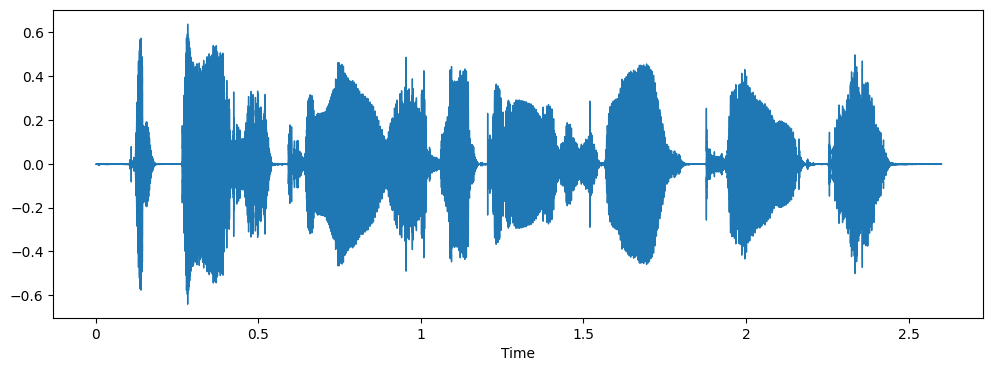

In [42]:
fig, ax = plt.subplots(figsize=(12,4))
librosa.display.waveshow(utt1, sr=sr, ax=ax)

display(Audio(utt1, rate=sr))



### Visualise a segment of the signal

The speech signal is an example of a non-stationary signal. To analyze the recording with more detail we can use an helper function to plot smaller segments of the signal. The libROSA waveshow() function is able to show the individual signal samples when the plot contains a sufficiently small number of samples

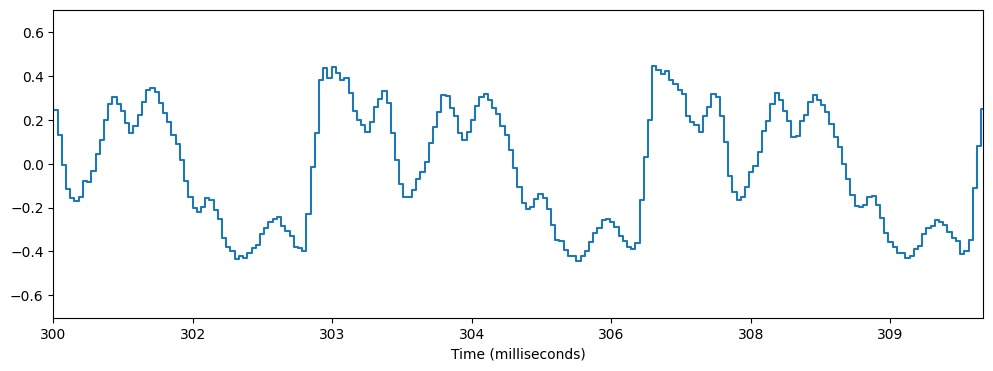

In [43]:

def waveshow_seg(x, fs, tmin=0, tmax=0):
    if (tmin < 0) or (tmin > x.size/fs):
        tmin = 0
    if (tmax <= 0) or (tmax > x.size/fs): 
        tmax = x.size/fs
    fig, ax = plt.subplots(figsize=(12,4))
    ax.set(xlim=[tmin, tmax])
    librosa.display.waveshow(x, sr=fs, axis='ms')
    return

start = 0.3
end = start + 0.01
waveshow_seg(utt1, sr, tmin=start, tmax=end)

# select the segment for playing
n_seg = np.arange(np.floor(start*sr), np.ceil(end*sr), dtype=int)
display(Audio(utt1[n_seg], rate=sr))

### Phonetic transcription

The phonetic transcription of the first utterance is:

The ðə
birch bɜːʧ
canoe kəˈnuː
slid slɪd
on ɒn
the ðə
smooth smuːð
planks plæŋks

Save utt1 into a wav file and use Audacity to locate the begining and end of the word "birch" and of the vowel [ɪ] in the word "slid".

In [44]:
import soundfile as sf
sf.write('utt1.wav', utt1, sr)

### T2: Locate the word "birch"

Initialize the variables `birch_start` and `birch_end` with the time instants inside `utt1` were the word birch is located. You can use Audacity for this. 

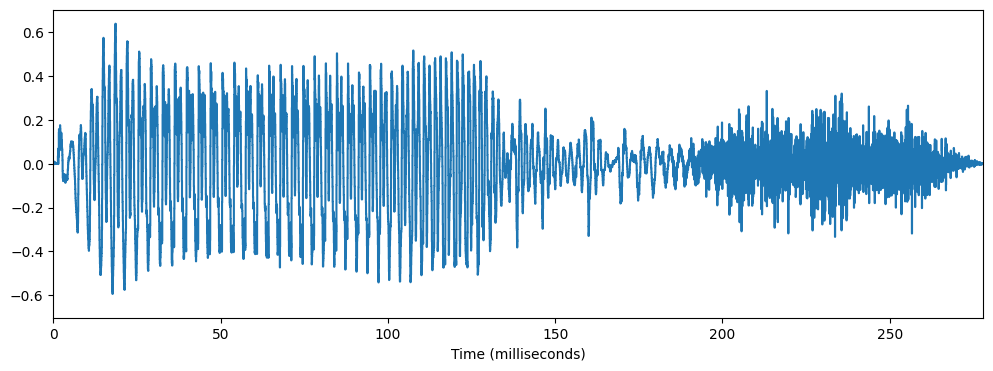

In [45]:
birch_start = 0.263
birch_end = 0.541

birch = utt1[int(birch_start*sr):int(birch_end*sr)]

display(Audio(birch, rate=sr))
waveshow_seg(birch, sr)

In [46]:
assert (birch_end - birch_start < 0.4) 

### T3: Locate vowel I

Define the variables `vowelI_start`and `vowelI_end` with the begining and end of vowel I in seconds.


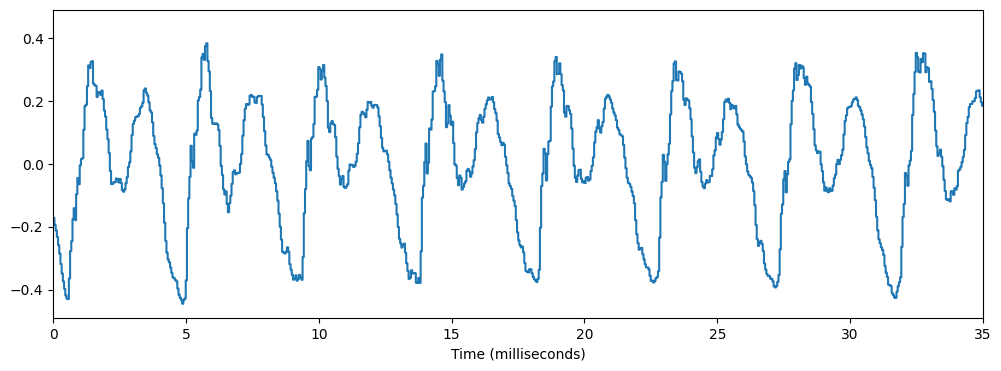

In [47]:
# TODO fix
vowelI_start = 1.095
vowelI_end = 1.123

vowelI_middle = vowelI_start + 0.5*(vowelI_end-vowelI_start)


vowelI = utt1[int(vowelI_start*sr):int(vowelI_end*sr)]
display(Audio(vowelI, rate=sr))
waveshow_seg(vowelI, sr)


In [48]:
assert (vowelI_end - vowelI_start < 0.1) 

### T4: Estimate the fundamental frequency at the center of vowel I

Estimate the fundamental frequency in the middle of the vowel and initialize the variable `vowelI_f0`

vowel I fundamental frequency is 212.00 Hz


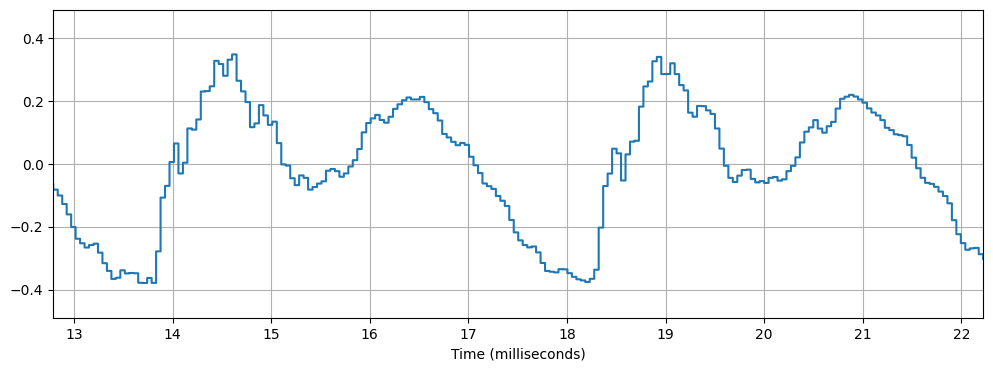

In [49]:
vowelI_f0 = 1 / (1.120 - 1.115)

vowelI_f0 = 210

print(f"vowel I fundamental frequency is {vowelI_f0:.2f} Hz")

mid = len(vowelI)//2/sr
waveshow_seg(vowelI, sr, tmin=mid-1/vowelI_f0, tmax=mid+1/vowelI_f0)
plt.grid()




In [50]:
assert (vowelI_f0 > 150) and (vowelI_f0 < 250)

### Record your own utterances



#### T5: Sentence

In the next text cell, write a sentence with a minimum of 6 words that includes the names of the students of the group and the vowels [a], [I] or [i], and [u]. The sentence can be in any language that both students speak.
Bellow the sentence write its phonetic transcription in IPA symbols.

O Duarte e a Leonor estudam muito.
u duaɾtɨ i ɐ ɫiunoɾ ʃtudɐ̃ʊ̃ mũjtu

#### T6: Record your voices

Use Audacity to record and produce two audio files, one with each students voice saying the sentence. Don't forget to trim the recordings but leave around 300 ms of silence at the ends. Use a sample rate of 22050 Hz.

Load the signals to variables `student1_utt` and `student1_utt`.

The original wav files should be included in the zip archive together with this notebokk to be submitted to Fenix system before the lab assignment due date.

In [51]:
student1_utt, sr = librosa.load("audio_leonor.wav", sr=22050)
student1_utt = (10**(-3/20)) * student1_utt / np.max(np.abs(student1_utt)) # isto e necessario?

student2_utt = student1_utt # TODO colocar audio

In [52]:
display(Audio(student1_utt, rate=22050))
display(Audio(student2_utt, rate=22050))

## Frequency domain visualization

The spectrum is a representation of a signal in terms of magnitude and phase characteristics as a function of frequency. The discrete-time Fourier transform (DTFT) can be used to compute the frequency representation of a signal. However, the DTFT is a function of a real variable $\omega \in \mathbb{R}$ that needs to be sampled for use in a digital computer.

The sampled representation of the DTFT is called the discrete Fourier transform (DFT) that can be very efficiently computed using the fast Fourier transform (FFT):
$$
X(k) = \sum_{n=0}^{N-1} x(n) e^{-j \frac{2\pi}{N} kn},\; 0 \leq k \leq N-1
$$

Given the periodicity of the complex exponential $e^{-j \frac{2\pi}{N} kn}$, the definition of $X(k)$ results in a periodic sequence of period $N$. This is prevented by limiting the range of $k$.

The `mag_spectrum()` function plots $|X(k)|$, the magnitude of the spectrum of the sequence $x(n)$.

In [53]:
def mag_spectrum(x, fs, fmin=0, fmax=0, ax=None):
    """
    Plot the magnitude spectrum of sequence x using the sampling frequency fs
    """

    X = fft(x)
    X_mag_dB = np.absolute(X)
    
    # the DFT samples the frequency range with N points
    f = np.linspace(0,fs, X.size)
    
    # plot frequency range
    if (fmin < 0 or fmin>fs):
        fmin = 0
    if (fmax <= 0 or fmax>fs):
        fmax = fs/2
    
    # plot
    if ax == None:
        fig, ax = plt.subplots(figsize=(10,6))
    
    ax.set(xlim=(fmin, fmax))
    ax.plot(f, X_mag_dB)
    plt.xlabel('Frequency (Hz)')
    plt.grid()




### Vowel I full magnitude spectrum

Use the mag_spectrum function to show the peridodicity of the DFT

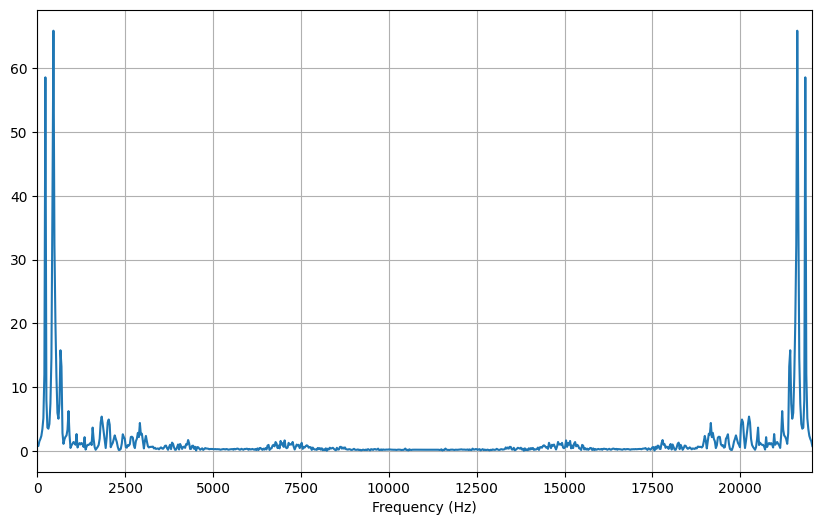

In [54]:
mag_spectrum(vowelI, sr, fmin=0, fmax=sr)

### Symmetry Property of the DFT

As shown in the previous plot, if $x(n)$ is a sequence of real values, the coefficients of it's DFT have the property that $|X(k)| = |X(N-k)|$. For this reason, we can limit the range of the spectrum to half of the sampling frequency without loss of information.

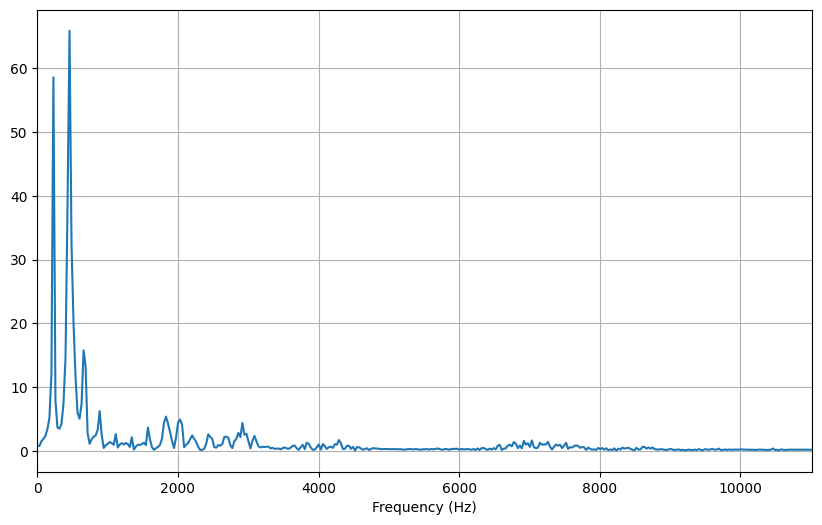

In [55]:
mag_spectrum(vowelI, sr)

### Decibels relative to full scale (dBFS)

Decibels relative to full scale (dBFS) is a measure of amplitude levels in decibels.

If $v$ is the amplitude of the signal that we want to measure and $v_{0}$ a reference amplitude, the amplitude ratio in decibels is:
$$
L_{dB} = 20 \log_{10}\left( \frac{v}{v_{0}}\right)
$$

The measure of decibels realtive to full scale (dBFS) assumes that $v_0$ is the maximum possible value for $v$ such that:
$$
L_{dBFS}(v_{0}) = 0\ dB
$$

When the amplitude is at 50% of the maximum level:
$$
L_{dBFS}\left( \frac{v_{0}}{2} \right) \approx -6\ dB
$$

Many signals resulting from an analog to digital conversion are represented in an amplitude range of $[-1,1]$, which means that $v_{0}=1$.



In [56]:
def mag_spectrum_dB(x, fs, fmin=0, fmax=0, ax=None):
    """
    Plot the magnitude spectrum in decibels of sequence x using the sampling frequency fs
    """

    X = fft(x)
    X_mag_dB = 20*np.log10(np.absolute(X))
    
    
    # the DFT samples the frequency range with N points
    f = np.linspace(0,fs, X.size)

    # plot frequency range
    if (fmin < 0 or fmin>fs):
        fmin = 0
    if (fmax <= 0 or fmax>fs):
        fmax = fs/2
    
    # plot
    if ax == None:
        fig, ax = plt.subplots(figsize=(10,6))
    ax.set(xlim=(fmin, fmax))
    ax.plot(f, X_mag_dB)
    plt.xlabel('Frequency (Hz)')
    plt.grid()
    return ax


### Vowel I magnitude spectrum in dB


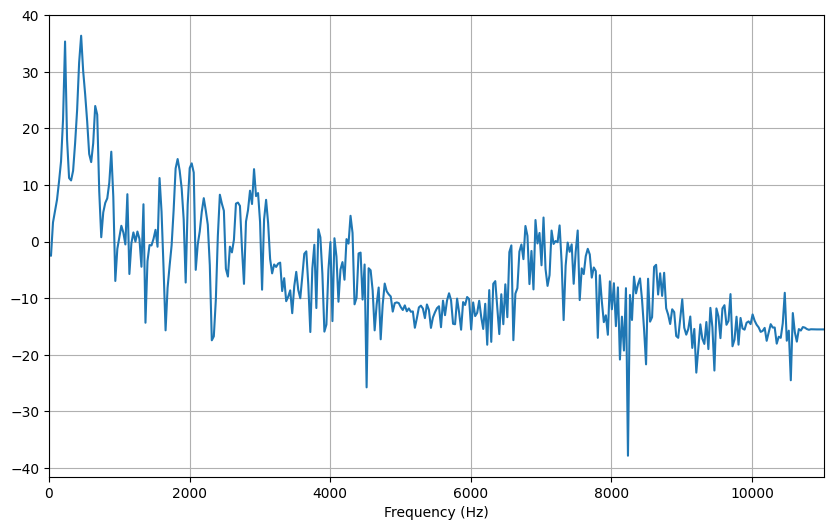

In [57]:
mag_spectrum_dB(vowelI, sr)
plt.show()


#### T7: Linear vs logarithmic amplitudes

In the following text box compare the differences between the magnitude spectrum expressed in linear or logarithmic amplitudes. What are the advantages of the representation in decibels?

*TODO escrever bonito*

By plotting the magnitude spectrum in a logarithmic scale, we are able to visualize variations in magnitude of frequency.
The advantage of this representation is that it emulates our own hearing. We also listen in logarithmic scale, that's why we can both hear a pin drop a plane fly nearby.

### Windowing

The function `mag_spectrum_dB()` computes da DFT with the same lenght as the input vector `x`. However, the FFT is more efficient when the lenght of the signal is a power of 2.

<AxesSubplot: xlabel='Frequency (Hz)'>

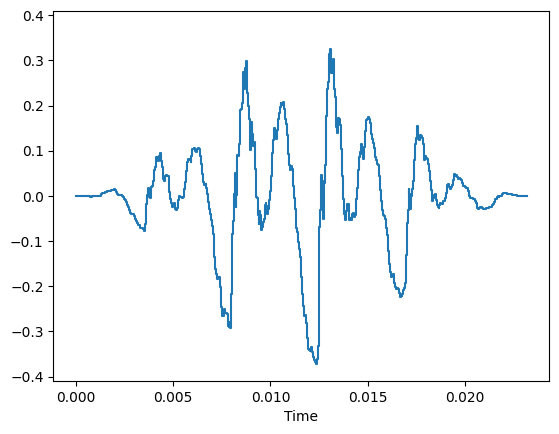

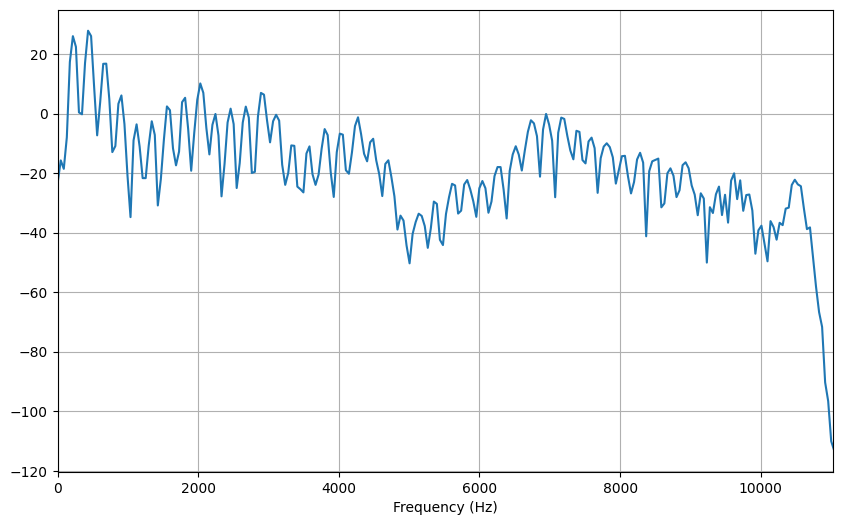

In [58]:
N = 512
win = np.hanning(N)
midpoint = int(sr*(vowelI_middle-vowelI_start))
vowI = vowelI[midpoint-(N//2):midpoint+(N//2)]*win
librosa.display.waveshow(vowI, sr=sr)
mag_spectrum_dB(vowI, sr, fmin=0, fmax=sr/2)

#### Narrow-band magnitude spectrum

The DFT samples the DTFT in as many samples as the length of the signal. To have a higher frequency resolution (a narrow-band analysis) we need longer window.

In [59]:
N = 1024
win = np.hanning(N)
midpoint = int(sr*(vowelI_middle-vowelI_start))
vowI_1024 = vowelI[midpoint-(N//2):midpoint+(N//2)]*win
librosa.display.waveshow(vowI_1024, sr=sr)
mag_spectrum_dB(vowI_1024, sr, fmin=0, fmax=sr/2)

ValueError: operands could not be broadcast together with shapes (127,) (1024,) 

#### Wide-band magnitude spectrum

With a lower frequency resolution (a wide-band analysis) the envelope of the magnitude spectrum show the resonances of the vocal tract.

<AxesSubplot: xlabel='Frequency (Hz)'>

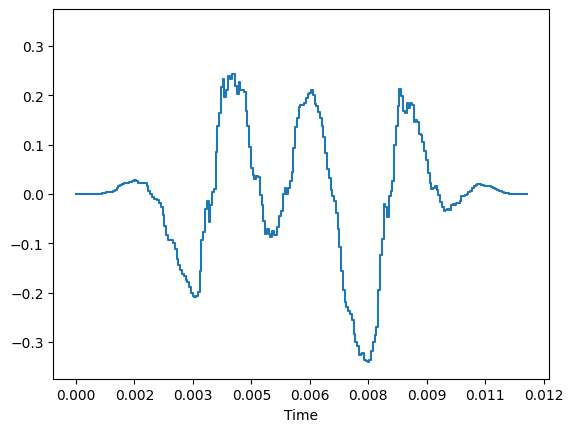

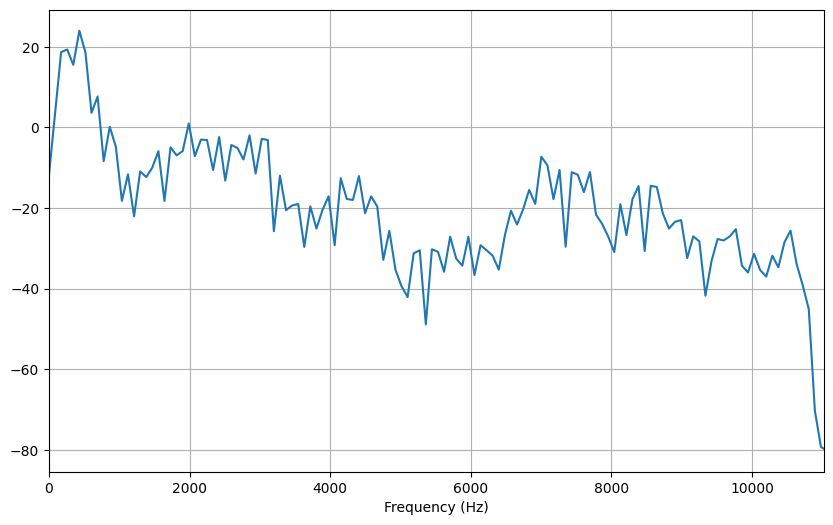

In [ ]:
N = 256
win = np.hanning(N)
midpoint = int(sr*(vowelI_middle-vowelI_start))
vowI_256 = vowelI[midpoint-(N//2):midpoint+(N//2)]*win
librosa.display.waveshow(vowI_256, sr=sr)
mag_spectrum_dB(vowI_256, sr, fmin=0, fmax=sr/2)

#### Harmonic spectrum

The quasi-periodicity of the vowel sound results in the presence of harmonic peaks in the magnitude spectrum.

The frequency representation of the harmonic peaks depend on the window function used to weight the time samples

<AxesSubplot: xlabel='Frequency (Hz)'>

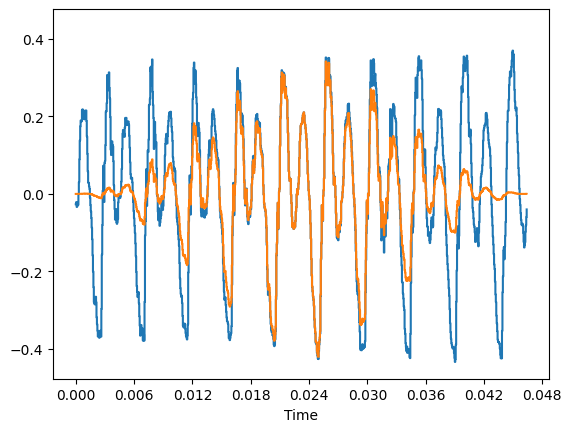

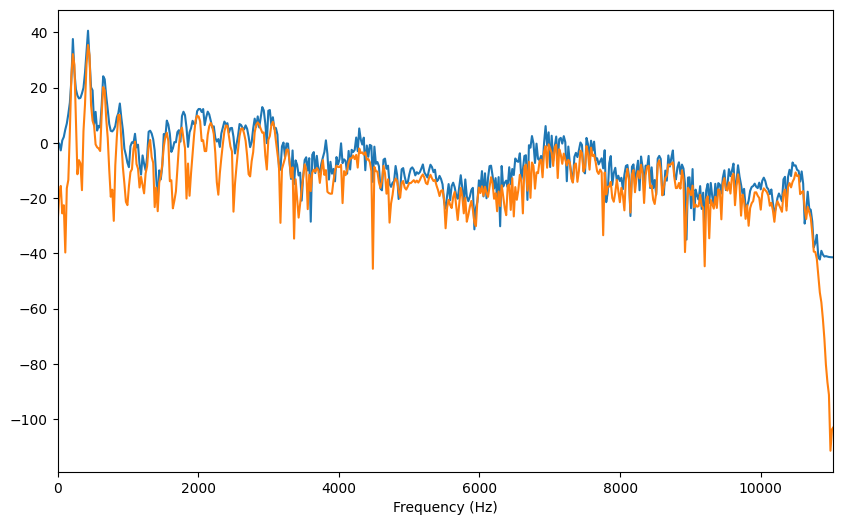

In [ ]:
N = 1024
win1 = np.ones(N)
win2 = np.hanning(N)
midpoint = int(sr*(vowelI_middle-vowelI_start))
vowI_win1 = vowelI[midpoint-(N//2):midpoint+(N//2)]*win1
vowI_win2 = vowelI[midpoint-(N//2):midpoint+(N//2)]*win2
librosa.display.waveshow(vowI_win1, sr=sr)
librosa.display.waveshow(vowI_win2, sr=sr)
ax = mag_spectrum_dB(vowI_win1, sr, fmin=0, fmax=sr/2)
mag_spectrum_dB(vowI_win2, sr, fmin=0, fmax=sr/2, ax=ax)


#### T8: Differences between windows

In the next text box explain the diferences observed is the magnitude spectrum resulting from the selection of the window.

* TODO *

Narrow vs. Wide: a larger value of N provides a better frequency resolution, which can be confirmed by the sharper magnitude peaks at certain frequencies. 

Rectangular vs. Hanning: rectangular has discontinuities at the edges of the frame, while Hanning filters shrink the signal towards 0 as we approach the window boundaries, thus avoiding the discontinuities. This is important because if there are discontinuities we cannot do Fourier analysis.

montes: vocal tract
riscas: ressonancias (forma da boca)
leakage: linha gorda (o laranja fica pior para o fim)
azul: é melhor para distinguir picos de frequencia mais proximas

### Linear Prediction Analysis

Linear prediction tries to predict a signal sample $\hat{s}(n)$ using a linear combination of the signal's past samples:
$$
\hat{s}(n) = \sum_{k=1}^{P} a_k s(n-k)
$$

The prediction error $e(n)$ is called the residue:
$$
e(n) = s(n) - \sum_{k=1}^{P} a_k s(n-k)
$$

This difference equation as the form of an all-zero filter with a transfer function $A(z)$ that is a polynomial in $z$:
$$
A(z) = 1 - \sum_{k=1}^{P} a_k z^{-k}
$$

The inverse of this filter is an all-pole filter that can be seen as similar to the vocal tract transfer function. In this case the residue can also be seen as an estimate of the glottal excitation.

If the signal is assumed to be quasi-stationary, the linear prediction coefficients $a_k$ can be found by finding the values that minimizes the energy of the prediction error (residue):
$$
a_k = \text{argmin}  \sum_{n=-\infty}^{+\infty} \left( e(n) \right)^2
$$

This is an optimization problem where we want to minimize the error function:
$$
\cal{E} = \sum_{n=-\infty}^{+\infty} \left( s(n) - \sum_{k=1}^{P} a_k s(n-k) \right)^2
$$

Setting the derivative of the error to zero
$$
\frac{d \cal{E}}{d a_k} = 2 \sum_{n=-\infty}^{+\infty} \left( s(n) - \sum_{k=1}^{P} a_k s(n-k) \right) s(n-k) = 0
$$

Results in a set of $P$ equations with P unknowns ($a_k$). Using the autocorrelation function:
$$
R(k) = \sum_{n=-\infty}^{+\infty} s(n) s(n-k)
$$

The system of equations becomes:
$$
\mathbf{R} \mathbf{a} = \mathbf{\gamma}
$$
where $\mathbf{R}$ is a $P \times P$ matrix with elements $R_{k,i}=R(|k-i|)$, $\mathbf{a}$ is $P \times 1$ vector with the lpc coefficients $a_k$ and $\mathbf{\gamma}$ is $P \times 1$ vector with $\gamma_k = R(k)$.

The solution is:
$$
\mathbf{a} = R^{-1} \mathbf{\gamma}
$$

All the elements along the diagonals of the $\mathbf{R}$ matrix have the same value, that is, $\mathbf{R}$ is a Toeplitz matrix. The system of equations can be solved using the Levinson-Durbin recursion.

In [ ]:
def bias_autocorr(signal, order):
    """ Computes the autocorrelation of signal up to the order of the LPC analysis"""
    N = len(signal)
    r = np.zeros(order+1)
    r[0] = np.sum(signal**2)/N
    for k in range(1,order+1):
        r[k] = np.sum(signal[k:]*signal[:-k])/N
    return r

In [ ]:
def levison_durbin(r, order):
    """Solves the levinson-durbin recursion for the LPC analysis"""
    g = r[1] / r[0]
    a = np.array([g])
    v = (1 - g**2) * r[0]
    for m in range(1, order):
        g = (r[m+1] - np.dot(a, r[1:m+1])) / v
        a = np.r_[ g, a - g*a[m-1::-1] ]
        v *= 1 - g**2
    return np.r_[1, -a[::-1]]


In [ ]:
def lpc(signal, order):
    """Computes the LPC analysis of signal x up to order order"""
    return levison_durbin(bias_autocorr(signal, order), order)

#### LPC spectrum

The LPC spectrum is the frequency response of the all-pole system with the coefficients resulting from LPC analysis. The transfer function of the system is:
$$
H(z) = \frac{K}{A(z)}
$$
where $K$ is a gain factor.

To find the frequency response $z=e^{j\omega}$:
$$
H(e^{j\omega}) = \frac{K}{A(e^{j\omega})}
$$

The inverse filter is an all-zero filter, that is, a finite impulse response filter:
$$
H^{-1}(e^{j\omega}) = A(e^{j\omega})
$$
with impulse response:
$$
h^{-1}(n) = 1 - \sum_{k=1}^{P} a_k \delta(n-k)
$$
where $\delta(n)$ is the unit impulse.

The frequency response can be computed by inverting the DFT of the impulse response of the inverse filter.

In [ ]:
def lpc_spectrum_dB(x, fs, order, fmin=0, fmax=0, ax=None):
    """
    Plot the magnitude spectrum of sequence x
    using the sampling frequency fs
    """

    X = np.divide(1.0, fft(lpc(x, order), len(x)))
    X_mag_dB = 20*np.log10(np.abs(X))
    
    # the DFT samples the frequency range with N points
    f = np.linspace(0,fs, X.size)
    
    # plot frequency range
    if (fmin < 0 or fmin>fs):
        fmin = 0
    if (fmax <= 0 or fmax>fs):
        fmax = fs/2
    
    # plot
    if ax == None:
        fig, ax = plt.subplots(figsize=(10,6))
    ax.set(xlim=(fmin, fmax))
    ax.plot(f, X_mag_dB)
    plt.xlabel('Frequency (Hz)')
    plt.grid()
    return ax

#### LPC order

The order of the LPC analysis should be adjusted in order to model the resonances of the vocal tract in the selected frequency range.

The analysis of a lossless tube show that it has one resonance in every 1000 Hz frequency band. Since each ressonance requires 2 filter coefficients, it is common to chose an LPC order equal to sampling frequency divide by 1000 plus an addicional ressonance to allow the presence of a nasal zero.

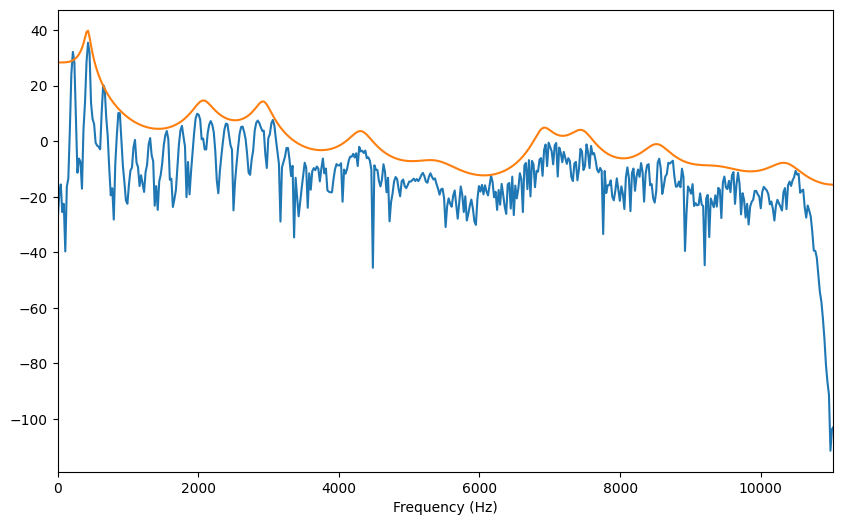

In [ ]:
N = 1024
win = np.hanning(N)
order = sr//1000 + 2
midpoint = int(sr*(vowelI_middle-vowelI_start))
vowI_1024 = vowelI[midpoint-(N//2):midpoint+(N//2)]*win
ax = mag_spectrum_dB(vowI_1024, sr)
ax = lpc_spectrum_dB(vowI_1024, sr, order, ax=ax)
plt.show()

#### T9: Compute the LPC error or residue

The all-zeros filter can be used to estimate the LPC error or residue. The residue signal should have less energy than the original signal and shows periodic pulses.

If we assume that the LPC filter is an estimate of the vocal tract, residue signal is an estimate of the voicing source necessary to produce the vowel.

The function scipy.signal.lfilter() implements a difference equation. Initialize the vectors `b` and `a` with the filter parameters

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()
vowI_1024_resid = sig.lfilter(b, a, vowI_1024)
librosa.display.waveshow(vowI_1024, sr=sr)
librosa.display.waveshow(vowI_1024_resid, sr=sr)



NotImplementedError: 

In [ ]:
assert np.average(np.abs(vowI_1024_resid)) < np.average(np.abs(vowI_1024))

### Mel frequency spectrum

The mel spectrum is a frequency representation where the frequencies are spaced acording to the mel scale and not evenly spaced like in the DFT. The mel is scales of frequencies such that each unit is judged by listeners to be equal in pitch distance from the next.

The mel frequency scale can be approximated by:
$$
m(f) = 2595 \log_{10} \left( 1 + \frac{f}{700} \right)
$$

To compute a mel frequency spectrum, a series of overlapping triangle filters are applied to the magnitudes of the FFT spectrum. Each FFT value is multiplied by its corresponding value in each triangle filter. The resulting values are then summed up for each filter, creating a series of energy values in each mel frequency band. This process is often referred to as "mel filtering".

The amplitudes of the filters can be normalized, so that each triangle has the same area, or not normalized, where all the filters have the same amplitude.



In [ ]:
def mel_spectrum_dB(x, fs, n_mels, fmin=0, fmax=0, ax=None):
    """
    Plot the magnitude spectrum of sequence x
    using the sampling frequency fs
    """

    
    # plot frequency range
    if (fmin < 0 or fmin>fs):
        fmin = 0
    if (fmax <= 0 or fmax>fs):
        fmax = fs/2

    # mel scale spectrum  with n_mels bins, norm='slaney' does area normalization
    X = librosa.feature.melspectrogram(y=vowI_1024, sr=sr, norm=None, n_fft=N, hop_length=N, n_mels=n_mels, center=False)
    X_mag_dB = 10*np.log10(np.abs(X))
    
    # mel scale frequencies
    f = librosa.mel_frequencies(n_mels=n_mels, fmax=sr//2)

    # plot
    if ax == None:
        fig, ax = plt.subplots(figsize=(10,6))
    ax.set(xlim=(fmin, fmax))
    ax.plot(f, X_mag_dB)
    plt.xlabel('Frequency (Hz)')
    plt.grid()
    return ax

#### Mel frequency resolution

To represent a signal in a mel scale, one needs to define the number of filters in which to divide the frequency range.

The number of filters used can vary depending on the specific application and the characteristics of the signal being analyzed. Typically, between 20 and 40 filters are used, with higher numbers of filters providing more detailed information about the frequency content of the signal. 

In [ ]:
N = 1024
win = np.hanning(N)
n_mels = 16
midpoint = int(sr*(vowelI_middle-vowelI_start))
vowI_1024 = vowelI[midpoint-(N//2):midpoint+(N//2)]*win


ax = mag_spectrum_dB(vowI_1024, sr)
mel_spectrum_dB(vowI_1024, sr, n_mels, ax=ax)
plt.show()

### Mel-frequency cepstral coefficients (MFCC)


The computation of the MFCCs takes the following steps:

1. Compute the discrete Fourier transform (DFT) of the signal
$$
X(k)=\sum_{n=0}^{N-1} x(n) e^{-j\frac{2\pi}{N}kn},\;0 \leq k \leq N-1
$$

2. Compute the mel-frequency spectrum:

$$
M(r) = \frac{1}{A_{r}} \sum_{k=L_{r}}^{U_{r}} |V_{r}(k) X(k)|
$$
where $V_{r}(k)$ is the triangular weighting function for the 𝑟-th filter, $L_{r}$ and $U_{r}$ are the lower and upper indices of the frequencies of the triangular filter, $A_r$ is the amplitude normalization factor of the filter. This groups the DFT values in critical bands.

3. Compute the discrete cosine transform (DCT) of the logarithm of the magnitude of the filter outputs:

$$
MFCC(m) = \frac{1}{R} \sum_{r=1}^{R} \ln(M(r)) \cos\left( \frac{\pi}{R}\left( r + \frac{1}{2} \right)m \right)
$$
where $R$ is the number of mel filters.

The MFCC coefficients provide a more compact representation of the signal spectral contents when compared, for example, with the mel-frequency spectrum.

In [ ]:
def mfcc_dB(x, n_mfcc):
    """
    Plot the mel frequency coefficients (MFCC) of sequence x
    """


    # mel scale spectrum  with n_mels bins, norm='slaney' does area normalization
    n_mels = n_mfcc
    X = librosa.feature.melspectrogram(y=vowI_1024, sr=sr, norm='slaney', n_fft=N, hop_length=N, n_mels=n_mels, center=False)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(X), n_mfcc=n_mfcc)

    k = np.arange(0, n_mfcc, 1)

    # plot

    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(k, mfccs)
    plt.xlabel('MFCC')
    plt.grid()
    return ax

#### MFCC visualization

In [ ]:
N = 1024
win = np.hanning(N)
n_mfcc = 20
midpoint = int(sr*(vowelI_middle-vowelI_start))
vowI_1024 = vowelI[midpoint-(N//2):midpoint+(N//2)]*win


mfcc_dB(vowI_1024, n_mfcc)
plt.show()

## Non-stationary signals: signal framing

Most of real-world signals are non-stationary. Since most signal processing techniques assume that the signal is stationary, it is common to split the original signal into short segments, called frames. To assume that the signal is quasi-stationary in these shorter segments frames are typically chosen to be of 10 to 100 ms in duration. The variable `frame_length` contais the number of samples in each frame.

To prevent large discontinuities when using frames to extract features from the signal, it is also common to use overlapping frames. This means that the next analysis frame includes samples that were also included is previous frames. The variable `hop_length` contais the number of samples between the start of two consecutive frames.

In [ ]:
frame_length = 1024
hop_length = 256

### Zero padding

In many application we need to reconstruct a signal by recombining overlapping frames. To be able to reconstruct a signal with, at least, the same length of the original the signal needs to be extended with zeros. This is called zero padding.



In [ ]:
def pad_signal(x, frame_length, hop_length):
    """Pads the signal x so that it can be split into frames of length frame_length with hop_length in between"""
    N = len(x)
    N_frames = N//hop_length + (N%hop_length > 0)
    x_padded = np.zeros((N_frames-1)*hop_length + frame_length)
    x_padded[:N] = x
    return x_padded


#### Test zero padding

To test the pad_signal() function we will use a we will use a chirp signal. A chirp signal is a type of signal that varies its frequency over time. In this case we will use a linear chirp signal with decreasing frequency.

In [ ]:
dur = 1
c_sr = 22050
t = np.linspace(0, dur, int(dur*c_sr), endpoint=False)
fmax = 300
fmin = 150

f = np.linspace(fmax, fmin, len(t))
c = np.sin(2*np.pi*f*t)
display(Audio(c, rate=sr))

c_pad = pad_signal(c, frame_length, hop_length)
c_nframes = (len(c)+hop_length-frame_length)//hop_length
c_pad_nframes = (len(c_pad)+hop_length-frame_length)//hop_length
print(f"Length of c signal: {len(c)}")
print(f"Number of frames of c signal: {c_nframes}")
print(f"Number of frames of c_pad signal: {c_pad_nframes}")
print(f"Length of reconstructed signal {c_pad_nframes}x{hop_length}={c_pad_nframes*hop_length}")


### Zero crossing rate

The number of times a signal crosses the x axis is an indication of the behaviour of the signal. For this reason, the zero crossing rate is a common feature for audio classification.

In [ ]:
def zero_crossing_rate(x):
    return np.sum(np.abs(np.diff(np.sign(x)))/2)/len(x)

#### T10: Write a function to compute the frame-based zero crossing rate

The previous function computes the zero crossing rate on a segment of the signal. To show how this feature changes in time you need to split the signal in overlapping frames and apply the function zero_crossing_rate() for each frame.

Make sure to use the pad_signal() function to have the right number of frames.

In [ ]:
def frame_based_zcr(x, frame_length, hop_length):
    """Computes the zero crossing rate of signal x by splitting it into frames of length frame_length with hop_length in between"""
# YOUR CODE HERE
raise NotImplementedError()
    return zcr

In [ ]:

assert(len(frame_based_zcr(c, frame_length, hop_length)) > len(c)/hop_length)

#### Test the frame-based zero crossing rate



In [ ]:
plt.plot(frame_based_zcr(c, frame_length, hop_length))
plt.xlabel('Frame number')
plt.ylabel('Zero crossing rate')

#### Speech zero crossing rate

To understand the meaning of the zero crossing rate feature we will see how it changes over a word of the first utterance of the Harvard set.

In [ ]:

birch_zcr = frame_based_zcr(birch, frame_length, hop_length)

##waveshow_seg(birch, sr)
display(Audio(birch, rate=sr))

t = np.arange(len(birch_zcr)) * hop_length / sr
librosa.display.waveshow(birch, sr=sr)
plt.plot(t, birch_zcr)
plt.show()


#### T11: Explain the relevance of the zero crossing rate

In the next text cell explain the variation of the zero crossing rate in the two graphs and why it is a relevant feature.

YOUR ANSWER HERE

### short-time Fourier transform (STFT)

The short-time Fourier transform is a type of Fourier analysis used to determine the frequency content of a signal over short, fixed-length time intervals. It is used in many applications, such as speech processing and musical analysis. The STFT is based on the conventional Fourier transform, but it divides the signal into overlapping segments and then performs a Fourier analysis for each segment. This results in a two-dimensional representation of the signal, where the frequency is on one axis and time on the other. Different resolutions can be obtained for analyzing different aspects of the signal by varying the size and position of the segments.

The signal segmentation is performed by multiplying the signal by a window function $w(n)$ that is zero-valued outside a specified interval. For example the rectangular window:
$$
w_{r}(n) =
\begin{cases}
1, & 0 \le n \le M-1 \\
0, & \text{otherwise}
\end{cases}
$$

The short-time Fourier transform, $X(n, \omega)$ is a two-dimensional representation of the signal $x(n)$:
$$
X(n, \omega) = \sum_{m=-\infty}^{+\infty} x(n+m)w(m) e^{-j\omega (n+m)} 
$$

If we use the discrete Fourier transform (DFT):

$$
X(n,k) = \sum_{m=0}^{M-1}x(n+m)w(m) e^{-j \frac{2\pi}{M}(n+m)},\ 0\le k \le M-1
$$


### Spectrogram of a signal

The spectrogram of a time-domain signal is a representation of the magnitude of the short-time Fourier transform (STFT) ($X(n,k)$) of a signal.

To facilitate the analysis of the signal, it is common to use the time axis in seconds or milliseconds and the frequency axis in Hz. The value of the amplitude of the spectrum at each point is represented with a darker color for low values and brighter color for higher values.

For better visualization of the entire range of amplitudes, it is frequent to represent them in decibels (dB).

The short-time Fourier transform can be computed with the `librosa.stft()` function. The resulting linear amplitudes need to be converted to dB. The function `librosa.display.specshow()` function can then be used to display the spectrogram as a frequency versus time representation of the signal.

In [ ]:
def spectrogram(x, fs, n_fft=512, win_length=512, hop_length=64, window='hann'):
    D = librosa.stft(x, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window)
    DAbsdB = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return DAbsdB



#### Spectrogram of the word "birch"

Use the spectrogram() function to plot the spectrogram of the word "birch".

In [ ]:

DAbsdB = spectrogram(birch, sr)
fig, ax = plt.subplots(figsize=(10,8))
img = librosa.display.specshow(DAbsdB, ax=ax, x_axis='time', y_axis='linear')
ax.set(title='Linear-frequency power spectrogram')
ax.label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

Audio(data=birch, rate=sr)

#### Wave and spectrogram visualization

It is frequently useful to have a simultaneous view of both the spectrogram and the time domain waveform aligned in time.

In [ ]:
def spec_wave_show(x, fs, tmin=0, tmax=0, n_fft=1024, win_length=1024, hop_length=128, window='hann'):
    """
    Plot a spectrogram and a waveform of a signal x
    """
    if (tmax == 0):
        tmax = x.shape[0]/fs
    nseg = np.arange(np.floor(tmin*fs), np.ceil(tmax*fs), dtype=int)

    D = librosa.stft(x, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window)
    DAbsdB = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    fig, ax = plt.subplots(figsize=(10,8), nrows=2, sharex=True, gridspec_kw={'height_ratios': [4, 1]})
    ax[0].set(xlim=[tmin, tmax])
    librosa.display.specshow(DAbsdB, n_fft=n_fft, win_length=win_length, hop_length=hop_length, sr=fs, ax=ax[0], x_axis='time', y_axis='linear')
    ax[0].set(title='Linear-frequency power spectrogram')
    librosa.display.waveshow(x, sr=fs, axis='time')
    display(Audio(data=x[nseg], rate=fs))
    plt.tight_layout()
    plt.show()
    return fig, ax

img, ax = spec_wave_show(birch, sr)

#### T12: Visualization of the plosive

In the previous spectrogram the plosive [b] is not visible in the spectrogram. Selected a frame size to make it more noticeable.


In [ ]:
# YOUR CODE HERE
raise NotImplementedError()
img, ax = spec_wave_show(birch, sr, n_fft=fsize, win_length=fsize, hop_length=fsize//4, window='hann')

In [ ]:
assert (fsize & (fsize-1) == 0) and fsize != 0

### Mel spectrogram

All frequency analysis made for a segment of the vowel I can be represented in a spectrogram plot. Such is the case of the mel-frequency spectrum

In [ ]:
def mel_spectrogram(y, sr, n_mels=128):
    # Compute mel-spectrogram
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    # Convert power to dB
    mel_spect_dB = librosa.power_to_db(mel_spect, ref=np.max)
    return mel_spect_dB

#### Test the mel spectrogram

In [ ]:
mel_spect = mel_spectrogram(birch, sr, n_mels=64)
plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_spect, y_axis='mel', x_axis='time')
plt.title('Mel-Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

### MFCC spectrogram

The mel-frequency cepstral coefficients (MFCC) can also be represented in a spectrogram.

In [ ]:
def mfcc(y, sr, n_mels=64, n_mfcc=13):
    # Compute mel-spectrogram
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    # Compute MFCCs from mel-spectrogram
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel_spect), n_mfcc=n_mfcc)
    return mfccs

#### Test the MFCC spectrogram

The MFCCs can capture the spectral stability. They are also less sentive to variations of the fundamental frequency than other representations

In [ ]:
mfccs = librosa.feature.mfcc(y=birch, sr=sr, n_mfcc=20)
fig, ax = plt.subplots(figsize=(10,8), nrows=3, sharex=True, gridspec_kw={'height_ratios': [3, 3, 1]})
librosa.display.specshow(mel_spect, ax=ax[0], x_axis='time', y_axis='mel')
librosa.display.specshow(mfccs, ax=ax[1], x_axis='time')
ax[1].set(ylabel='MFCC')
librosa.display.waveshow(birch, sr=sr, axis='time', ax=ax[2])
plt.tight_layout()

## Fundamental frequency estimation and voice/unvoice dection

The fundamental frequency is the frequency of the first harmonic of a periodic signal. In speech processing the fundamental frequency is often referred by f0 or pitch.

In this lab we will use the estimator pyin() provide by the libROSA package.

To show the performance of the algorithm in tracking the first harmonic of the signal we can plot the spectrogram in a logarithmic frequency scale and overlap the f0 values produced by the estimator.

You can see the f0 decay typical of a declarative utterance. You also observe the intonation break after the word "canoe".



In [ ]:
f0, voiced_flag, voiced_probs = librosa.pyin(utt1, fmin=100, fmax=360)
times = librosa.times_like(f0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(utt1)), ref=np.max)
fig, ax = plt.subplots(figsize=(10,8), nrows=2, sharex=True, gridspec_kw={'height_ratios': [4, 1]})
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='pYIN fundamental frequency estimation')
#fig.colorbar(img, ax=ax, format="%+2.f dB")
ax[0].plot(times, f0, label='f0', color='cyan', linewidth=4)
ax[0].legend(loc='upper right')
librosa.display.waveshow(utt1, sr=sr, axis='time', ax=ax[1])
plt.tight_layout()
display(Audio(data=utt1, rate=sr))

### Interpolation of f0 values

The frame-based fundamental frequency estimator produces a f0 value for every frame. We want to interpolate these values to have a value of f0 for every sample of the signal.

The function scipy.interpolate.interp1d() can help with the interpolation.

In [ ]:
from scipy.interpolate import interp1d

def sig_f0(x, sr, frame_length, hop_length):
    """Estimates and interpolates the F0 for every time sample of given signal x""" 
    t = np.linspace(0, len(x)/sr, len(x))
    x_pad = pad_signal(x, frame_length, hop_length)
    f0, voiced_flag, voiced_probs = librosa.pyin(x_pad, fmin=60, fmax=360, sr=sr, 
                                                 frame_length=frame_length, 
                                                 hop_length=hop_length)
    t_f0 = np.linspace(0, len(x)/sr, len(f0))
    # Interpolate the F0 estimates to cover the entire time range
    interpf0 = interp1d(t_f0, f0)
    f0i = interpf0(t)
    f0i = np.nan_to_num(f0i, nan=0)
    return f0i



#### Visualize the interpolated f0

In [ ]:
fsize = 1024
hop = 256
utt1_f0 = sig_f0(utt1, sr, fsize, hop)
t = np.linspace(0, len(utt1)/sr, len(utt1))
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(t, utt1_f0, label='f0')
librosa.display.waveshow(utt1, sr=sr, axis='time', ax=ax[1])
plt.tight_layout()

## T13: Write a function to compute interpolate RMS values 


The root mean square (RMS) of a sequence of $N$ values is the square root of the arithmetic mean of the squares of the values, that is
$$
x_{RMS}=\sqrt{ \frac{1}{N} \sum_{n=0}^{N-1}\left[x(n)\right]^{2}}
$$

The value $(x_{RMS})^{2}$ is the _power_ of a signal, that is, its _energy_ over a period time.

Write a function that computes the RMS value for each frame and then linearly interpolate the values to produce a vector with the same lenght as the speech signal.

In [ ]:
def sig_rms(x, frame_length, hop_length):
    """Computes and interpolates RMS values for every sample of a given signal x"""
# YOUR CODE HERE
raise NotImplementedError()
    return rmsi[0:N]

In [ ]:

assert np.isclose(np.sum(sig_rms(np.ones(3), 2, 1)), 3)

#### Visualize the interpolated RMS

In [ ]:
fsize = 1024
hop = 256
utt1_rms = sig_rms(utt1, fsize, hop)
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(t, utt1_rms, label='RMS')
librosa.display.waveshow(utt1, sr=sr, axis='time', ax=ax[1])
plt.tight_layout()

## Formant synthesizer

The resonances of the vocal tract, known as formants, can be accurately approximated as second order resonant filters. These formants are created by the shaping of the vocal tract, which acts as a series of resonant cavities. Each of these cavities has a resonant frequency, which determines the frequency at which it will naturally vibrate.

By using second order resonant filters to model these formants, the formant synthesizer can simulate the acoustic characteristics of the vocal tract, allowing it to produce vowel sounds and other vocal sounds.

In this example we will model the vocal tract with a cascade of two second order resonant filters.

### Second-order all-pole system


A second-order all-pole system has the following transfer function
$$
H(z) = \frac{K}{1-a_1 z^{-1} - a_2 z^{-2}}
$$
where $K$ is the static gain.

The transfer function that can be written in terms of its poles:
$$
H(z) = \frac{K}{(1-p_1 z^{-1})(1-p_2 z^{-1})}
$$

where $p_1$ and $p_2$ are the complex roots of the denominator of $H(z)$ known as poles.

If $K=1$, the system can be implemented as
$$
y(n) = x(n) + a_1 y(n-1) + a_2 y(n-2)
$$
where
$$
\begin{align}
a_1 &= p_1 + p_2\\
a_2 &= - p_1 p_2
\end{align}
$$

For this system to work as a resonator the poles must be complex conjugates of each other, that is, $p_1 = p_2^{\ast}$. In this case:
$$
\begin{align}
a_1 &= 2\Re\{p_1\}\\
a_2 &= - |p_1|^2
\end{align}
$$
A resonator is characterized by its natural frequency $\omega_n$ and damping ratio $zeta$. When $0<\zeta<1$ the system is underdamped and the poles are complex conjugates. 

When modeling the vocal tract each formant is defined by a frequency and a bandwidth,

The formant frequency is usually considered the undamped resonant frequency (or natural frequency):
$$
F = 2 \pi \omega_n
$$

The bandwidth is measured between the cutoff frequencies, most frequently defined as the frequencies at which the frequency response has fallen to half the value at its peak.
$$
B = f_{c_2} - f_{c_1} = \frac{\omega_n \zeta}{\pi}
$$

These continuous-time frequency values can be used to define the position of the poles of the continuous time transfer function:
$$
\omega_{peak} = \omega_n \sqrt{1-2\zeta^2}
$$

To find the corresponding discrete-time transfer function we need to map the poles into the z-plane:
$$
\begin{align}
p_1 &= e^{s_1 T}=e^{(-\zeta \omega_n + \omega_n \sqrt{\zeta^2 -1})T}\\
p_2 &= e^{s_2 T}=e^{(-\zeta \omega_n - \omega_n \sqrt{\zeta^2 -1})T}\\
\end{align}
$$



In [ ]:

def formant_filter_coeffs(F, B, sr):
    T = 1/sr
    wn = 2*np.pi*F
    zeta = 2*np.pi*B/(2*wn)
    s1 = -zeta*wn + 1j*wn*np.sqrt(1-zeta**2)
    s2 = -zeta*wn - 1j*wn*np.sqrt(1-zeta**2)
    p1 = np.exp(s1*T)
    p2 = np.exp(s2*T)
    a = np.poly([p1, p2])
    b = np.array([np.sum(a)])
    return b, a


### Formant filter frequency response

The function scypi.signal.freqz() can be used to get the samples of the frequency response of a system with a rational transfer function such as the formant filter.

In [ ]:
fsyn_sr = 8000
F1 = 500
B1 = 100

b, a = formant_filter_coeffs(F1, B1, fsyn_sr)
w, h = sig.freqz(b, a, worN=1024)
f = w/(2*np.pi)*fsyn_sr
plt.plot(f, 20*np.log10(abs(h)))
plt.grid()

### Cascading of two formant filters

Connecting the output of one formant filter to another results in the product of the transfer function of both filters
$$
H(z) = \frac{1}{1-a_{11} z^{-1} - a_{12} z^{-2}} \frac{1}{1-a_{11} z^{-1} - a_{22} z^{-2}}
$$
The resulting filter coefficients are the convolution of the filter parameters
$$
H(z) = \frac{1}{1 - 
(a_{11}+a_{12}) z^{-1} - 
(a_{12}-a_{11}a_{21}+a_{22}) z^{-2} -
(-a_{11}a_{22}-a_{12}a_{21}) z^{-3} -
(-a_{12}a_{22})z^{-4}}
$$



In [ ]:

F2 = 1500
B2 = 100
b1, a1 = formant_filter_coeffs(F1, B1, fsyn_sr)
b2, a2 = formant_filter_coeffs(F2, B2, fsyn_sr)
b = np.convolve(b1, b2)
a = np.convolve(a1, a2)
w, h = sig.freqz(b, a, worN=1024)
f = w/(2*np.pi)*fsyn_sr
plt.plot(f, 20*np.log10(abs(h)))
plt.grid()


### T14: Write a function to generate the source signal

For voiced sounds ($f_0>0$) the source signal is a train of impulses:
$$
e(n) = \sqrt{P} \sum_{k=-\infty}^{+\infty} \delta(n-kP)
$$
where $P=1/f_0$ is the fundamental period, and $\delta(n)$ is the unit impulse function.

For unvoiced sounds ($f_0=0$) the source signal is zero-mean unit-variance Gaussian white noise:
$$
e(n) \sim \mathcal{N} (0,1)
$$

Write a function that takes a f0 vector generated by the function sig_f0() and returns a vector with the same lenght with pulses or noise depending on the f0 estimate. Use basic Python and NumPy functions.


In [ ]:
def source_generator(f0, sr):
    """Generates a periodic pulse train with given fundamental frequency or with random noise if f0=0"""
# YOUR CODE HERE
raise NotImplementedError()
    return exc


In [ ]:
assert len(source_generator(np.ones(64), sr)) == 64

### T15: Synthesize 3 vowels

In the following code block generate 3 audio signals:
- `vowel_a` with samples of a synthesized vowel [a]
- `vowel_i` with samples of a synthesized vowel [I]
- `vowel_u` with samples of a synthesized vowel [u]

with the following characteristics

- Sample rate: 16000 Hz
- Use only two formants for each vowel
- Duration: 0.5 s
- Linearly decaying f0 from 220 Hz to 190 Hz
- Raised cosine RMS: starts and ends in zero and maximum amplitude at the middle of the vowel.

The values for the formant frequencies and bandwidths should be extracted from your recordings


In [ ]:
fsyn_sr = 16000

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
display(Audio(vowel_a, rate=fsyn_sr))
display(Audio(vowel_i, rate=fsyn_sr))
display(Audio(vowel_u, rate=fsyn_sr))

## LPC Vocoder

An LPC (Linear Predictive Coding) vocoder combines the LPC analysis and LPC synthesis.

We saw that in LPC analysis, the speech signal is modeled as a linear combination of past samples, and the model coefficients are a good estimation the signal's spectral envelope.

In the source-filter model, the vocal tract is responsible for speech signal's spectral envelope. If we assume that the vocal tract is an all-pole filter, the LPC coefficients can be used as the parameters for that filter.

Since the vocal tract changes in time, we need a filter that can also change in time






### Time varying overlap-add filter

Using the same approach that we used for analysing non-stationary signals, we can split the filtering process using a frame-by-frame approach.

The only difference is that we need to make sure that the signal framing process does not modify the amplitude of the reconstructed signal. This can be achieved, for example, by using
Hanning windows and an hop value equal to half of the frame length. This way, the sum of all windows equals one except in the first half of the first frame and in the last half of the last frame.

This process is called overlap-add filtering. 

In [ ]:
def variable_filter(b, a, x, frame_length=1024, hop_length=512):
    """Frame-based filtering with time-varying filter coefficients"""
    N = len(x)
    w = np.hanning(frame_length)
    x_pad = pad_signal(x, hop_length, hop_length)
    x_frames = librosa.util.frame(x_pad, frame_length=frame_length, hop_length=hop_length, axis=0)
    y_frames = np.zeros(x_frames.shape)
    min_frames = min(b.shape[0], a.shape[0], x_frames.shape[0])
    for f in range(min_frames):
        y_frames[f] = sig.lfilter(b[f], a[f], x_frames[f])
    # overlap_add
    y = np.zeros_like(x_pad)
    for n in range(0, len(x_pad) - frame_length, hop_length):
        y[n:n+frame_length] += y_frames[n//hop_length] * w
    return y[:N]


#### Test of the overlap-add filter

To test the time-varying filter we will use a fixed low pass filter 

In [ ]:
# 4th order Butterworth lowpass filter
fc = 3000
butter_b, butter_a = sig.butter(4, fc/sr, 'low')

# Number of frames
frame_length = 1024
hop_length = frame_length//2
nframes = len(utt1)//hop_length + (len(utt1)%hop_length >0)

# time-varying filter coefficients
b = np.tile(butter_b, (nframes, 1))
a = np.tile(butter_a, (nframes, 1))

# apply filter
utt1_lowp = variable_filter(b, a, utt1, frame_length, hop_length)
librosa.display.waveshow(utt1_lowp, sr=sr)
display(Audio(utt1, rate=sr))
display(Audio(utt1_lowp, rate=sr))

### T16: Frame-based LPC analysis

To generate the parameters of the LPC filter we need to perform an LPC analysis for every frame of the signal.
Use a Hanning window together with the lpc() function defined previously to compute the LPC parameters for each frame.

In [ ]:
def frame_based_lpc(x, order, frame_length, hop_length):
    """Computes frame-base LPC parameters of signal x"""
# YOUR CODE HERE
raise NotImplementedError()
    return lpc_coeffs

In [ ]:
assert (frame_based_lpc(np.sin(2*np.pi*np.arange(200)/20),10,100,50).shape[0] == 4)
assert (frame_based_lpc(np.sin(2*np.pi*np.arange(200)/20),10,100,50).shape[1] == 11)

#### Test of the frame-based LPC analysis

A good way to test the LPC analysis is by estimating the LPC error or residual signal that can be obtained by filtering the original signal with an all-zeros filter.


In [ ]:
order = 20
frame_length = 2048
hop_length = frame_length//2
lpc_coeffs = frame_based_lpc(utt1, order, frame_length, hop_length)
a = np.tile(1, (len(lpc_coeffs), 1))

utt1_resid = variable_filter(lpc_coeffs, a, utt1, frame_length, hop_length)
librosa.display.waveshow(utt1_resid, sr=sr)
display(Audio(utt1_resid, rate=sr))

### T17: Residual signal

By listening to the residual signal what can you conclude about the capacity of this LPC filter to model the vocal tract? What features may the model be missing?

YOUR ANSWER HERE

### T18: LPC synthesis

You now have all the tools to generate a synthetic version of the residue signal that can be used at the input of the all-poles LPC filter to synthesize a version of the original file.

In the second next code cell generate a synthetic version of the first Harvard sentence based on the LPC parameters, F0 and RMS estimation.

Use a downsampled version of `utt1` to see the effect of the original signal bandwith in the final result. Adjust tge LPC order to the signal's sampling rate.

Repeat with the recordings of the sentence spoken by both students

In [ ]:
new_sr = 16000
utt1_rs = librosa.resample(utt1, orig_sr=sr, target_sr=new_sr)

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
librosa.display.waveshow(utt1_syn, sr=new_sr)

display(Audio(utt1_rs, rate=new_sr))
display(Audio(utt1_syn, rate=new_sr))
display(Audio(student1_syn, rate=new_sr))
display(Audio(student2_syn, rate=new_sr))

#### T19: Robotic voice

Modify the previous code to generate an all voice signal with fixed fundamental frequency of $f_0 = 180 Hz$
Produce 3 synthetics signals: the first Harvard sentence and your sentence spoken by both students

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
librosa.display.waveshow(utt1_robotic, sr=new_sr)
display(Audio(utt1_robotic, rate=new_sr))
display(Audio(student1_robotic, rate=new_sr))
display(Audio(student2_robotic, rate=new_sr))

#### T20: whispered voice

Modify the previous code to generate a fully unvoice signal that simulates a whispered voice.
Produce 3 synthetics signals: the first Harvard sentence and your sentence spoken by both students

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
librosa.display.waveshow(utt1_whisper, sr=new_sr)
display(Audio(utt1_whisper, rate=new_sr))
display(Audio(student1_whisper, rate=new_sr))
display(Audio(student2_whisper, rate=new_sr))